In [1]:
import src.models

import orbax.checkpoint
from src.training import utils
import jax.numpy as jnp

Setup to load in checkpoint

In [5]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
y = (20.0,)
x0 = (1.0,)
T=1.
checkpoint_path = f"/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/guided/guided_data_y_{y}_x0_{x0}"

restored = orbax_checkpointer.restore(checkpoint_path)
model = src.models.score_mlp.ScoreMLP(**restored["network"])
params = restored["params"]

trained_score = utils.trained_score(model, params)


In [4]:
checkpt_path_1_20 =  "/Users/libbybaker/Documents/Python/doobs-score-project/doobs_score_matching/checkpoints/ou/guided/fixed_x0_(1.0,)_y(20.0,)"
restored = orbax_checkpointer.restore(checkpt_path_1_20)
model = src.models.score_mlp.ScoreMLP(**restored["network"])
params = restored["params"]

trained_score_1_20 = utils.trained_score(model, params)

In [7]:
# plt.rcParams.update(figsizes.neurips2023(nrows=2, ncols=3))
# fig, axs = plot_score_variable_y(true_score, trained_score, -1, 1, -1, 1, cmap=cmap)
# plt.savefig('ou_score_varied_y_-1.0_to_1.0.pdf')
# plt.show()

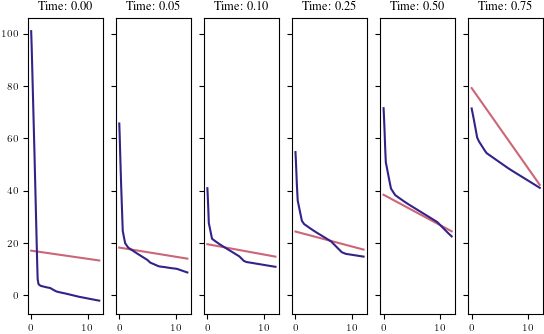

In [8]:
from src.plotting import plot_score

# plt.rcParams.update(figsizes.neurips2023(nrows=1, ncols=3))


fig, axs = plot_score(true_score, trained_score, T, y, x=jnp.linspace(0, 12, 1000)[..., None],
                      t=jnp.asarray([0.0, 0.05, 0.1, 0.25, 0.5, 0.75]),)
plt.show()

In [9]:
from src.data_generate_sde.utils import conditioned
from src.data_generate_sde import sde_ornstein_uhlenbeck as ou
import jax
import functools

keys = jax.random.split(jax.random.PRNGKey(0), 20)
ts = jnp.linspace(0, T, 100)

def generate_conditioned_trajs(keys, score_fn, ts, x0):
    drift, diffusion = ou.vector_fields()
    conditioned_fn = functools.partial(conditioned, ts=ts, x0=x0, score_fn=score_fn, drift=drift, diffusion=diffusion)
    conditioned_trajs = jax.vmap(conditioned_fn)(keys)
    return conditioned_trajs


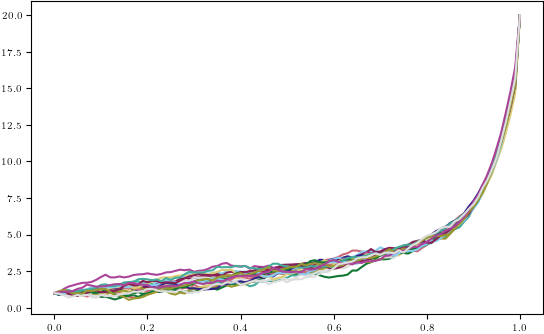

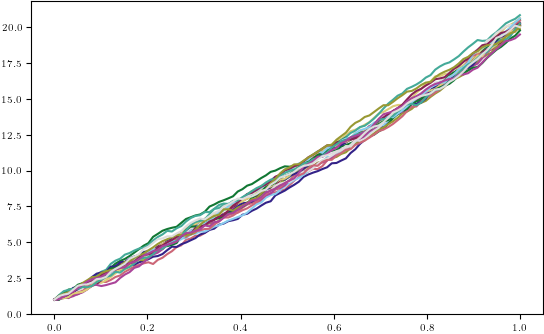

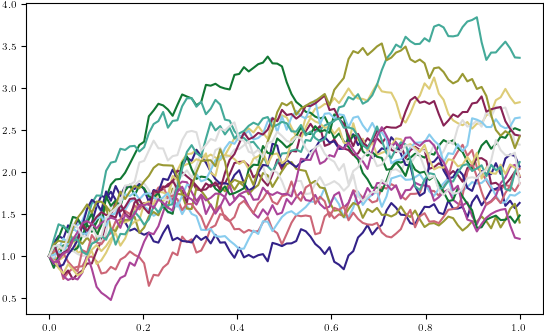

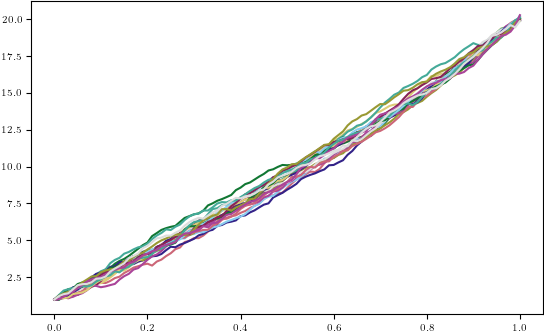

In [67]:
from src.data_generate_sde import sde_ornstein_uhlenbeck
from tueplots import bundles, axes, cycler, figsizes
from tueplots.constants.color import palettes
import matplotlib.pyplot as plt

bundle = bundles.neurips2023()
plt.rcParams.update(bundle)
plt.rcParams.update(cycler.cycler(color=palettes.paultol_muted))

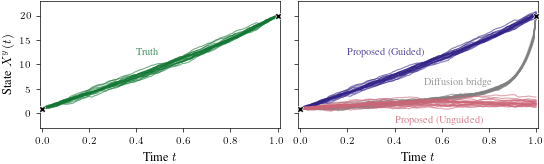

In [84]:
import numpy as np

plt.rcParams.update(figsizes.neurips2023(nrows=1, ncols=2))
plt.rcParams.update(axes.lines())
# fig, axs = plt.subplots(nrows=2, ncols=2, )
fig, axs = plt.subplot_mosaic([["true", "approx"]], sharex=True, sharey=True)
line_width = 0.5 

bridged_db_x01_y20 = np.load("/Users/libbybaker/Documents/Python/DiffusionBridge/bridged_db_x01_y20.npy")

ts_101 = np.linspace(0, 1, 101)
ts= np.linspace(0, 1, 100)

plot_kwargs = {"linewidth": .8, "alpha": 0.6}
annotate_kwargs = {"fontsize": "small", "alpha": 0.8}

for traj in bridged_db_x01_y20:
    axs["approx"].plot(ts_101, traj, color="grey", **plot_kwargs)

axs["approx"].annotate("Diffusion bridge", xy=(0.525, 6), color="grey", **annotate_kwargs)
    
guided_trajs = generate_conditioned_trajs(keys, trained_score, ts, x0)
for traj in guided_trajs:
    axs["approx"].plot(ts, traj, color="C1", **plot_kwargs)
    
axs["approx"].annotate("Proposed (Guided)", xy=(0.2, 12), color="C1", **annotate_kwargs)

unguided_trajs = generate_conditioned_trajs(keys, trained_score_1_20, ts, x0)
for traj in unguided_trajs:
    axs["approx"].plot(ts, traj, color="C0", **plot_kwargs)
    
axs["approx"].annotate("Proposed (Unguided)", xy=(0.4, -2), color="C0", **annotate_kwargs)

    
true_score = functools.partial(ou.score, T=1.0, y=(20.0,))
true_traj = generate_conditioned_trajs(keys, true_score, ts, x0)
for traj in true_traj:
    axs["true"].plot(ts, traj, color="C3", **plot_kwargs)

axs["true"].annotate("Truth", xy=(0.4, 12), color="C3", **annotate_kwargs)
    
for ax in axs["approx"], axs["true"]:
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-3, 23)
    ax.set_xlabel("Time $t$")
    ax.plot([0, 1], [1, 20], marker="X",markersize=5, markeredgewidth=0.5, linestyle="None", zorder=10, color="black", markeredgecolor="white")
    
    
axs["true"].set_ylabel(r"State $X^y(t)$")
plt.savefig("ou_guided_vs_unguided.pdf")